In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime
from glob import glob
import scipy
import scipy.misc
import pickle
from tqdm import tqdm_notebook as tqdm
%matplotlib inline  

In [2]:
def get_batch(images, batch_size, index):
    start_idx = index * batch_size
    end_idx = (index + 1) * batch_size        
    batch  = images[start_idx: end_idx]
    return batch

In [3]:
def weight_variable(shape):
    return tf.Variable(tf.random_normal(shape, mean=0.0, stddev=0.01))

def bias_variable(shape):
    return tf.Variable(tf.random_normal(shape, mean=0.0, stddev=0.01))

def layer(x, shape, activation):
    W = weight_variable(shape)
    b = bias_variable([shape[1]])
    return activation(tf.matmul(x, W) + b)

In [4]:
image_size = 64 * 64 * 3
latent_dim = 100
encoder_internal_dim = decoder_internal_dim = 2048

input_shape = [None, image_size]
x = tf.placeholder(tf.float32, input_shape)

softplus = tf.nn.softplus
tanh = tf.nn.tanh

h_enc1 = layer(x, [image_size, encoder_internal_dim], activation=softplus)
h_enc2 = layer(h_enc1, [encoder_internal_dim, encoder_internal_dim], activation=softplus)
h_enc3 = layer(h_enc2, [encoder_internal_dim, encoder_internal_dim], activation=softplus)

W_mu = weight_variable([encoder_internal_dim, latent_dim])
b_mu = bias_variable([latent_dim])

W_log_sigma = weight_variable([encoder_internal_dim, latent_dim])
b_log_sigma = bias_variable([latent_dim])

    
z_mu = tf.matmul(h_enc3, W_mu) + b_mu
z_log_sigma = tf.matmul(h_enc3, W_log_sigma) + b_log_sigma

# reparametarization trick

# noise gaussian ε ~ N(0, 1)
epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], latent_dim]))

# z = μ+σ^(1/2)*ε
z = z_mu + tf.exp(z_log_sigma/2) * epsilon


h_dec1 = layer(z, [latent_dim, decoder_internal_dim], activation=softplus)
h_dec2 = layer(h_dec1, [decoder_internal_dim, decoder_internal_dim], activation=softplus)
h_dec3 = layer(h_dec2, [decoder_internal_dim, decoder_internal_dim], activation=softplus)

# log(p(x|z)) (p is Bernoulli) reconstruction loss
y = layer(h_dec3, [decoder_internal_dim, image_size], activation=tf.nn.sigmoid)
recon = -tf.reduce_sum(x * tf.log(y + 1e-10) + (1 - x) * tf.log(1 - y + 1e-10), 1)/image_size


# KLD(q(z|x)||p(z)) ~ -(1/2) * sum(1 + log(sigma^2) - mu^2 - sigma^2)
kl_div = - (1/2)* tf.reduce_sum(1.0 + 2.0 * z_log_sigma - tf.square(z_mu) - tf.exp(2.0 * z_log_sigma),1)/image_size

 

cost = tf.reduce_mean(recon + kl_div)
cost_kl = tf.reduce_mean(kl_div)
cost_recon = tf.reduce_mean(recon)


In [5]:
if not os.path.exists("./model/"):
    os.mkdir("./model/")

In [6]:
% rm -rf img/
% mkdir img/


def create_images(i, sess, test_images, num_examples=20, image_size=28*28):
    h = w = int(np.sqrt(image_size/3))
    
    original = get_batch(test_images, num_examples, 0)
    reconstruction = sess.run(y, feed_dict={x: original})
    
    fig, axs = plt.subplots(2, num_examples, figsize=(20, 2))
    for example_i in range(num_examples):
        axs[0][example_i].imshow(np.reshape(original[example_i, :], (h, w, 3)),cmap='gray')
        axs[1][example_i].imshow(np.reshape(np.reshape(reconstruction[example_i, ...], (image_size,)),(h, w, 3)),cmap='gray')
        #axs[0][example_i].imshow(np.reshape(original[example_i, :], (h, w)),cmap='gray')
        #axs[1][example_i].imshow(np.reshape(np.reshape(reconstruction[example_i, ...], (image_size,)),(h, w)),cmap='gray')
        axs[0][example_i].axis('off')
        axs[1][example_i].axis('off')
    fig.savefig('img/reconstruction_%08d.png' % i)
    plt.close()

    
def create_latent_scatter_images(i, sess, test_images,test_labels):
    zs = sess.run(z, feed_dict={x: test_images})
    fig, ax = plt.subplots(1, 1)
    ax.clear()
    ax.scatter(zs[:, 0], zs[:, 1], c=np.argmax(test_labels, 1), alpha=0.2)
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.axis("off")
    fig.savefig("img/latent_scatter_%08d.png"% i)
    plt.close()

In [7]:
data = glob(os.path.join("./model/", "model*"))
latest_ckpt = sorted(data)[-1].split(".meta")[0]
latest_ckpt

'./model/model_2017_09_23_10_47_43.ckpt'

In [ ]:
def train(train_images, validation_images, test_images, test_labels=[], image_size=28*28, learning_rate = 0.005):
    saver = tf.train.Saver()
    sess = tf.Session()
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    sess.run(tf.global_variables_initializer())
    if latest_ckpt:
        saver.restore(sess, latest_ckpt)
    
    batch_size = 50
    num_epochs = 10000

    num_train_batches = len(train_images) // batch_size
    num_validation_batches = len(validation_images) // batch_size

    print("num of train batches: ", num_train_batches)
    print("num of validation batches: ", num_validation_batches)

    i = 0
    for epoch in range(num_epochs):
        print("epoch no.", epoch)
        
        for batch_idx in tqdm(range(num_train_batches)):            
            batch  = get_batch(train_images, batch_size, batch_idx)
            sess.run(optimizer, feed_dict={x: batch})
            #print("z: ", sess.run(z, feed_dict={x: batch}))
            #print("h_dec1: ", sess.run(h_dec1, feed_dict={x: batch}))
            #print("h_dec2: ", sess.run(h_dec2, feed_dict={x: batch}))
            #print("h_dec3: ", sess.run(h_dec3, feed_dict={x: batch}))
            #print("y: ", sess.run(y, feed_dict={x: batch}))
      
            
         
        train_cost = sess.run(cost, feed_dict={x: batch})
        print("train cost per a batch: ", train_cost)
        i += 1
        create_images(i, sess, test_images, num_examples=10, image_size=image_size)
        #create_latent_scatter_images(i, sess, test_images, test_labels)
        print("cost_kl: ", sess.run(cost_kl, feed_dict={x: batch}))
        print("cost_recon: ", sess.run(cost_recon, feed_dict={x: batch}))
      

        valid_cost = 0
        for j in range(num_validation_batches):
            batch  = get_batch(validation_images, batch_size, j)
            valid_cost += sess.run(cost, feed_dict={x: batch})
        print("validation cost per a batch: ", valid_cost / num_validation_batches)
        now = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
        save_path = saver.save(sess, "model/model_{}.ckpt".format(now))
        print("Model saved in file: %s" % save_path)


In [8]:
def get_z(images):
    batch_size = 50
    n_batches = 1 + len(images) // batch_size
    print("num of  batches: ", n_batches)
    saver = tf.train.Saver()
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    if latest_ckpt:
        saver.restore(sess, latest_ckpt)
    z_list = []
    for idx in tqdm(range(n_batches)):
        batch  = get_batch(images, batch_size, idx)
        z_list.append(sess.run(z, feed_dict={x: batch}))
    return np.concatenate(z_list, axis=0)

In [9]:
def imread(path):
    return scipy.misc.imread(path).astype(np.float)

def resize_width(image, width=64.):
    h, w = np.shape(image)[:2]
    return scipy.misc.imresize(image,[int((float(h)/w)*width),width])
        
def center_crop(x, height=64):
    h= np.shape(x)[0]
    j = int(round((h - height)/2.))
    return x[j:j+height,:,:]

def get_image(image_path, width=64, height=64):
    return center_crop(resize_width(imread(image_path), width = width),height=height)

def load_img_data(data):
    images = np.zeros((len(data),dim*dim*3), dtype = np.float)
    for i, d in enumerate(tqdm(data)):
        image = get_image(d, dim,dim)
        images[i] = image.flatten()/255.
    return images

In [10]:
data = glob(os.path.join("./data/celebA", "*.jpg"))
data = np.sort(data)
print(data[0:10])
print("num of data: ", len(data))

['./data/celebA/000001.jpg' './data/celebA/000002.jpg'
 './data/celebA/000003.jpg' './data/celebA/000004.jpg'
 './data/celebA/000005.jpg' './data/celebA/000006.jpg'
 './data/celebA/000007.jpg' './data/celebA/000008.jpg'
 './data/celebA/000009.jpg' './data/celebA/000010.jpg']
num of data:  202599


In [11]:
data = data[:50000]

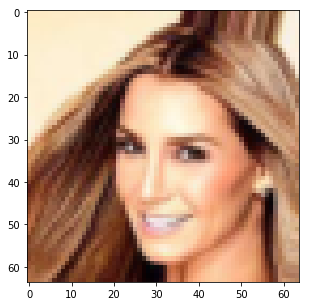

In [12]:
dim = int(np.sqrt(image_size/3))
test = get_image(data[0],dim,dim)
cm = plt.cm.hot
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,5))
ax.imshow(np.reshape(test, (dim,dim,3)), interpolation='nearest')

In [ ]:
image_batch_size = 10000
n_image_batches = 1 + len(data) // image_batch_size

if os.path.exists("./images_0.pickle"):
    print("loading from pickles")
    images_list = []
    for i in tqdm(range(n_image_batches)):
        file_name = "./images_{}.pickle".format(i)
        with open(file_name, mode='rb') as f:
            images_list.append(pickle.load(f))
    images = np.concatenate(images_list, axis=0)
    del images_list[:]
    del images_list
else:
    images =  load_img_data(data)
        
    for i in range(n_image_batches):
        image_batch = get_batch(images, image_batch_size, i)
        file_name = "./images_{}.pickle".format(i)
        with open(file_name ,mode='wb') as f:
            pickle.dump(image_batch, f, protocol=4)

In [13]:
images = load_img_data(data)

In [14]:
len(images)

50000

In [15]:
images[0].shape

(12288,)

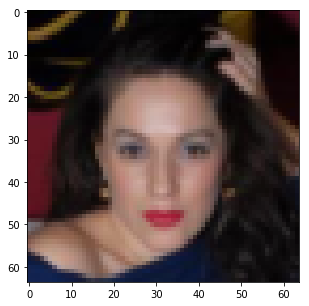

In [16]:
test = images[-1]
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,5))
ax.imshow(np.reshape(test, (dim,dim,3)), interpolation='nearest')

In [ ]:
train_images = images[50:]
validation_images = images[:50]
test_images = images[:10]

In [ ]:
#train(train_images, validation_images, test_images, test_labels=[], image_size=image_size, learning_rate = 0.0005)

In [17]:
z_list = get_z(images)

num of  batches:  1001
INFO:tensorflow:Restoring parameters from ./model/model_2017_09_23_10_47_43.ckpt



In [18]:
len(z_list)

50000

In [19]:
from scipy.spatial import distance
pairwise = distance.squareform(distance.pdist(z_list, metric="cosine"))

In [20]:
def similar_to(img_id, num=5, distance=False):
    img = pairwise[img_id]
    ids = np.argsort(img)[0: num] 
    if distance:
        dist = np.sort(img)[0: num]
        return [(x,y) for x, y in zip(ids, dist)]
    else:
        return ids

def show_sim_image(img_id):
    id_list = similar_to(img_id)
    dim = int(np.sqrt(image_size/3))
    for id in id_list:
        test = get_image(data[id],dim,dim)
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,5))
        ax.imshow(np.reshape(test, (dim,dim,3)), interpolation='nearest')

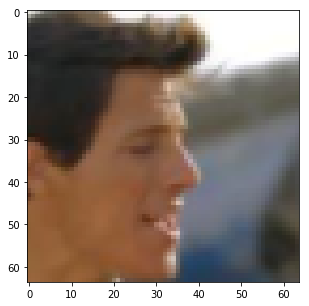

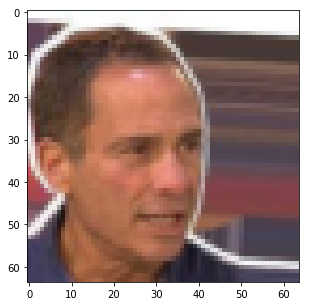

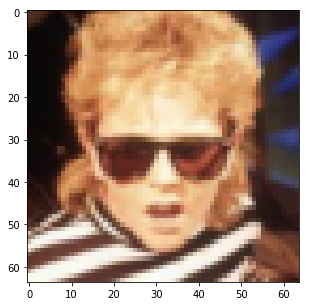

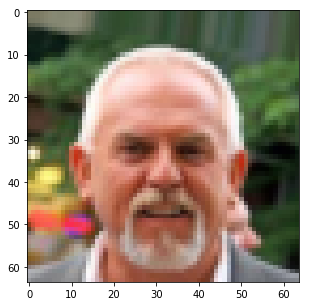

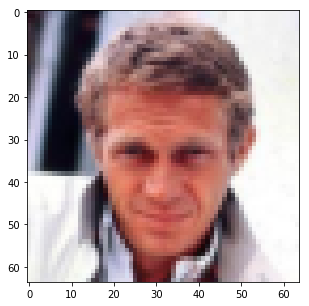

In [23]:
show_sim_image(2)

In [ ]:
# mnist

In [ ]:
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist = input_data.read_data_sets('MNIST_DATA', one_hot=True)

In [ ]:
train_images = mnist.train.images
validation_images = mnist.validation.images
test_images = mnist.test.images
test_labels = mnist.test.labels

In [ ]:
train_images[0].shape

In [ ]:
train(train_images, validation_images, test_images, test_labels, image_size=28*28)